# Polarized observations

This tutorial covers working with polarized instrument and maps, and recovering polarized maps from observations.

We start with a normal instrument, and create two orthogonally polarized copies of each detector by setting ``polarized: True`` in the ``Array`` config:

In [1]:
import maria
from maria.instrument import Band

f090 = Band(
    center=90e9,  # in Hz
    width=20e9,  # in Hz
    NET_RJ=40e-6,  # in K sqrt(s)
    knee=1e0,    # in Hz
    gain_error=5e-2)

f150 = Band(
    center=150e9, 
    width=30e9, 
    NET_RJ=60e-6, 
    knee=1e0, 
    gain_error=5e-2)

array = {"field_of_view": 0.5, 
         "shape": "circle", 
         "beam_spacing": 1.5,
         "primary_size": 10, 
         "polarized": True,
         "bands": [f090, f150]}

instrument = maria.get_instrument(array=array)

print(instrument.arrays)

          n     FOV baseline        bands polarized
array1  652  0.478°      0 m  [f090,f150]      True


We can see the resulting polarization footprint in the instrument plot:

Instrument(1 array)
├ arrays:
│            n     FOV baseline        bands polarized
│  array1  652  0.478°      0 m  [f090,f150]      True
│ 
└ bands:
      name   center   width    η         NEP      NET_RJ         NET_CMB     FWHM
   0  f090   90 GHz  20 GHz  0.5  5.445 aW√s  40 uK_RJ√s  49.13 uK_CMB√s   1.458’
   1  f150  150 GHz  30 GHz  0.5  12.25 aW√s  60 uK_RJ√s    104 uK_CMB√s  0.8748’


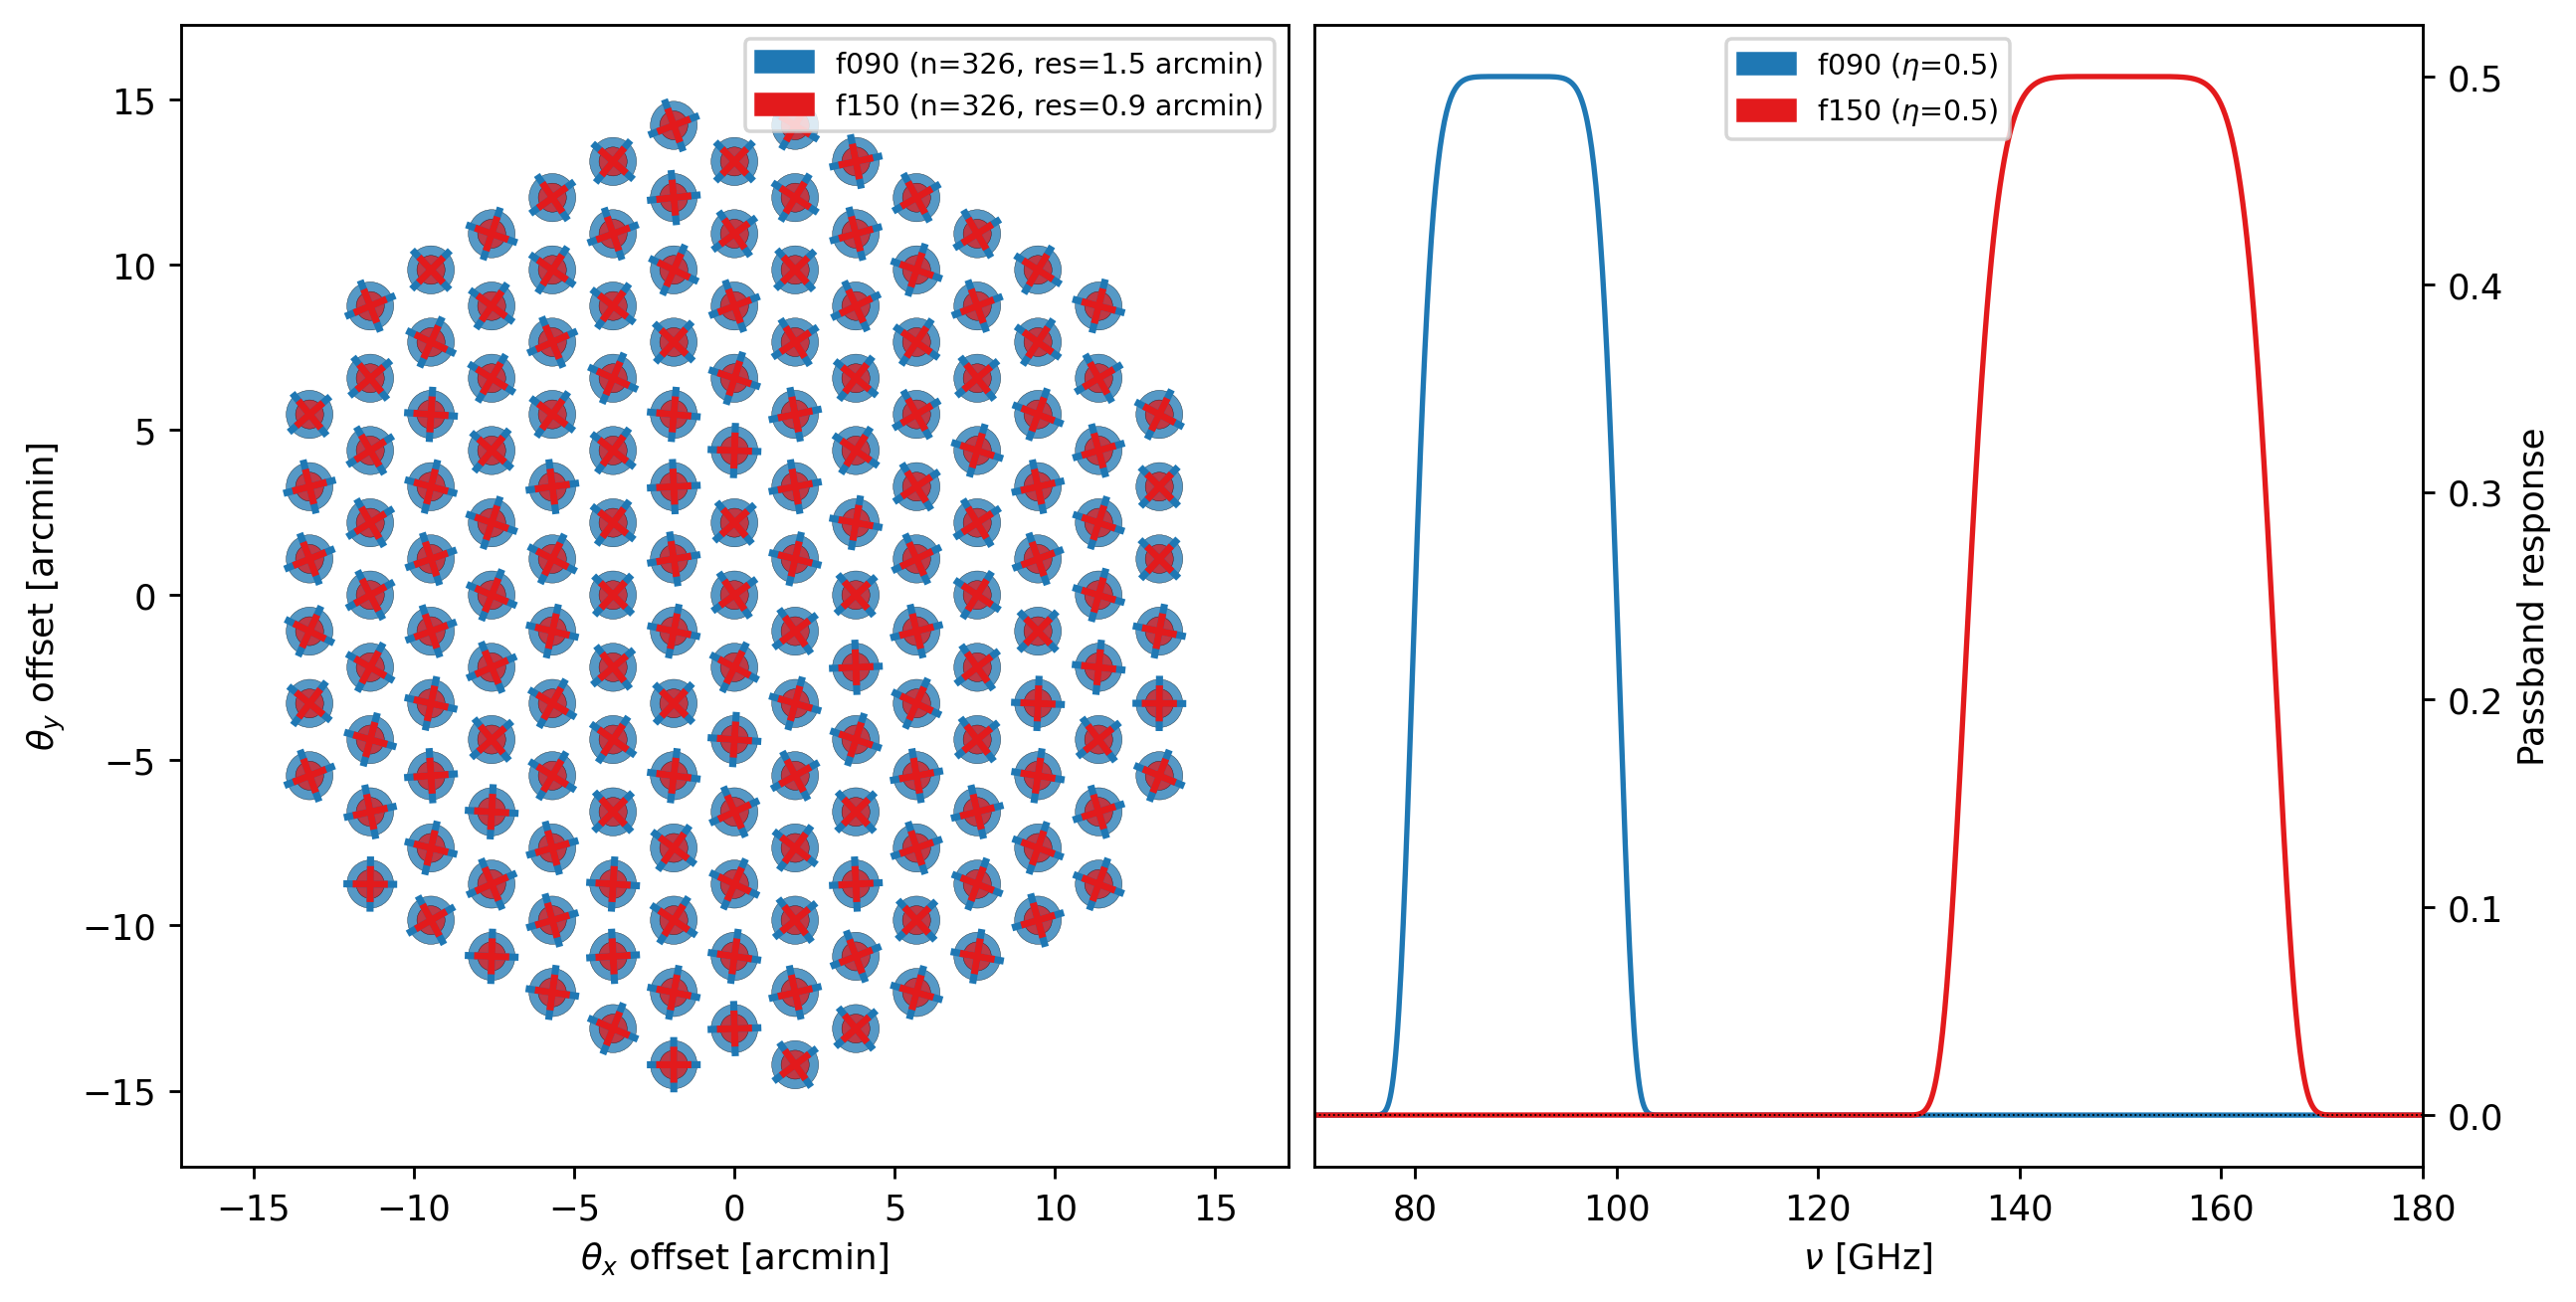

In [2]:
print(instrument)
instrument.plot()

Let's observe the use the Einstein map, which has a faint polarization signature underneath the unpolarized signal of Einstein's face. Remember that all maps are five dimensional (stokes, frequency, time, y, x); this map has four channels in the stokes dimensions (the I, Q, U, and V [Stokes parameters](https://en.wikipedia.org/wiki/Stokes_parameters)). We can plot all the channels by giving ``plot`` a shaped set of stokes parameters.

2025-11-10 15:36:06.842 INFO: Fetching https://github.com/thomaswmorris/maria-data/raw/master/maps/einstein.h5


Downloading:   0%|                | 0.00/931k [00:00<?, ?B/s]

Downloading: 100%|████████████████| 931k/931k [00:00<00:00, 46.5MB/s]

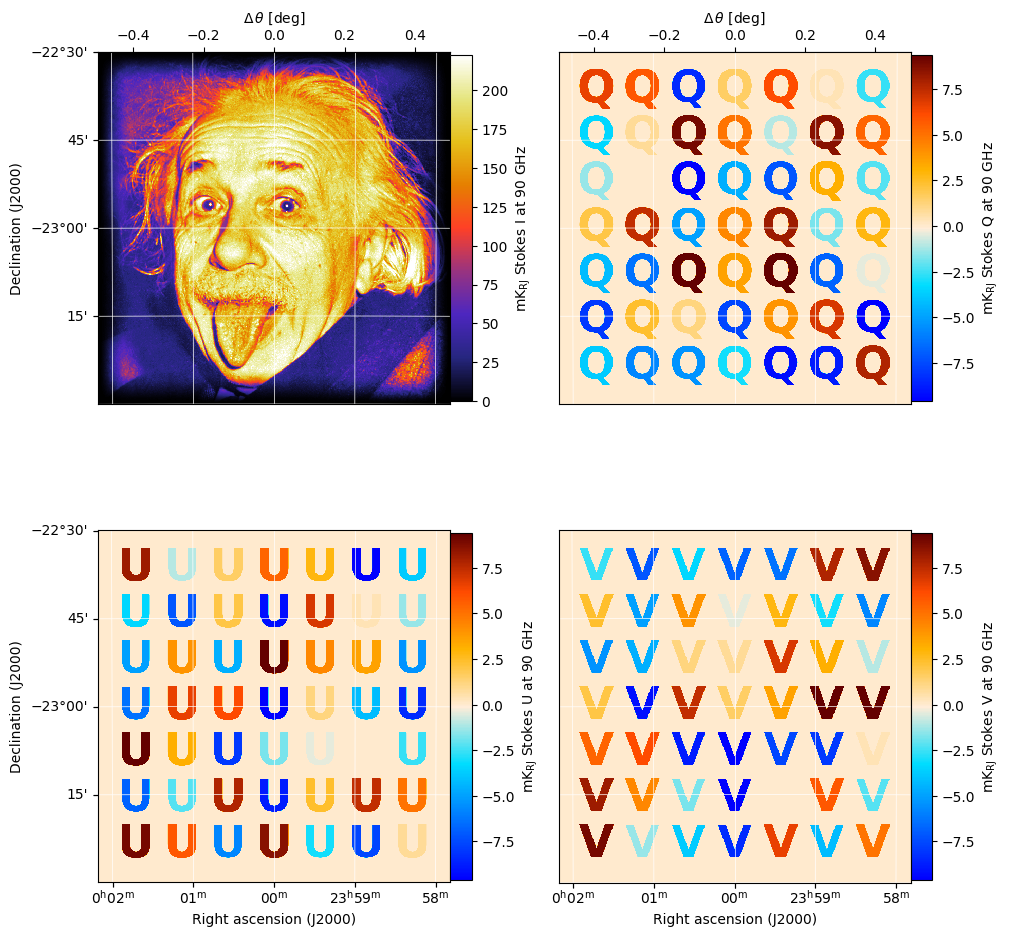

In [3]:
from maria.io import fetch

input_map = maria.map.load(fetch("maps/einstein.h5"))
input_map.plot(stokes=[["I", "Q"], 
                       ["U", "V"]])

PlanList(2 plans, 900 s):
                           start_time duration     target(ra,dec)    center(az,el)
chunk                                                                             
0      2025-11-10 23:00:32.767 +00:00    600 s       (360°, -23°)  (95.92°, 61.2°)
1      2025-11-10 23:11:10.267 +00:00    300 s  (2.721’, -23.01°)  (95.5°, 63.02°)


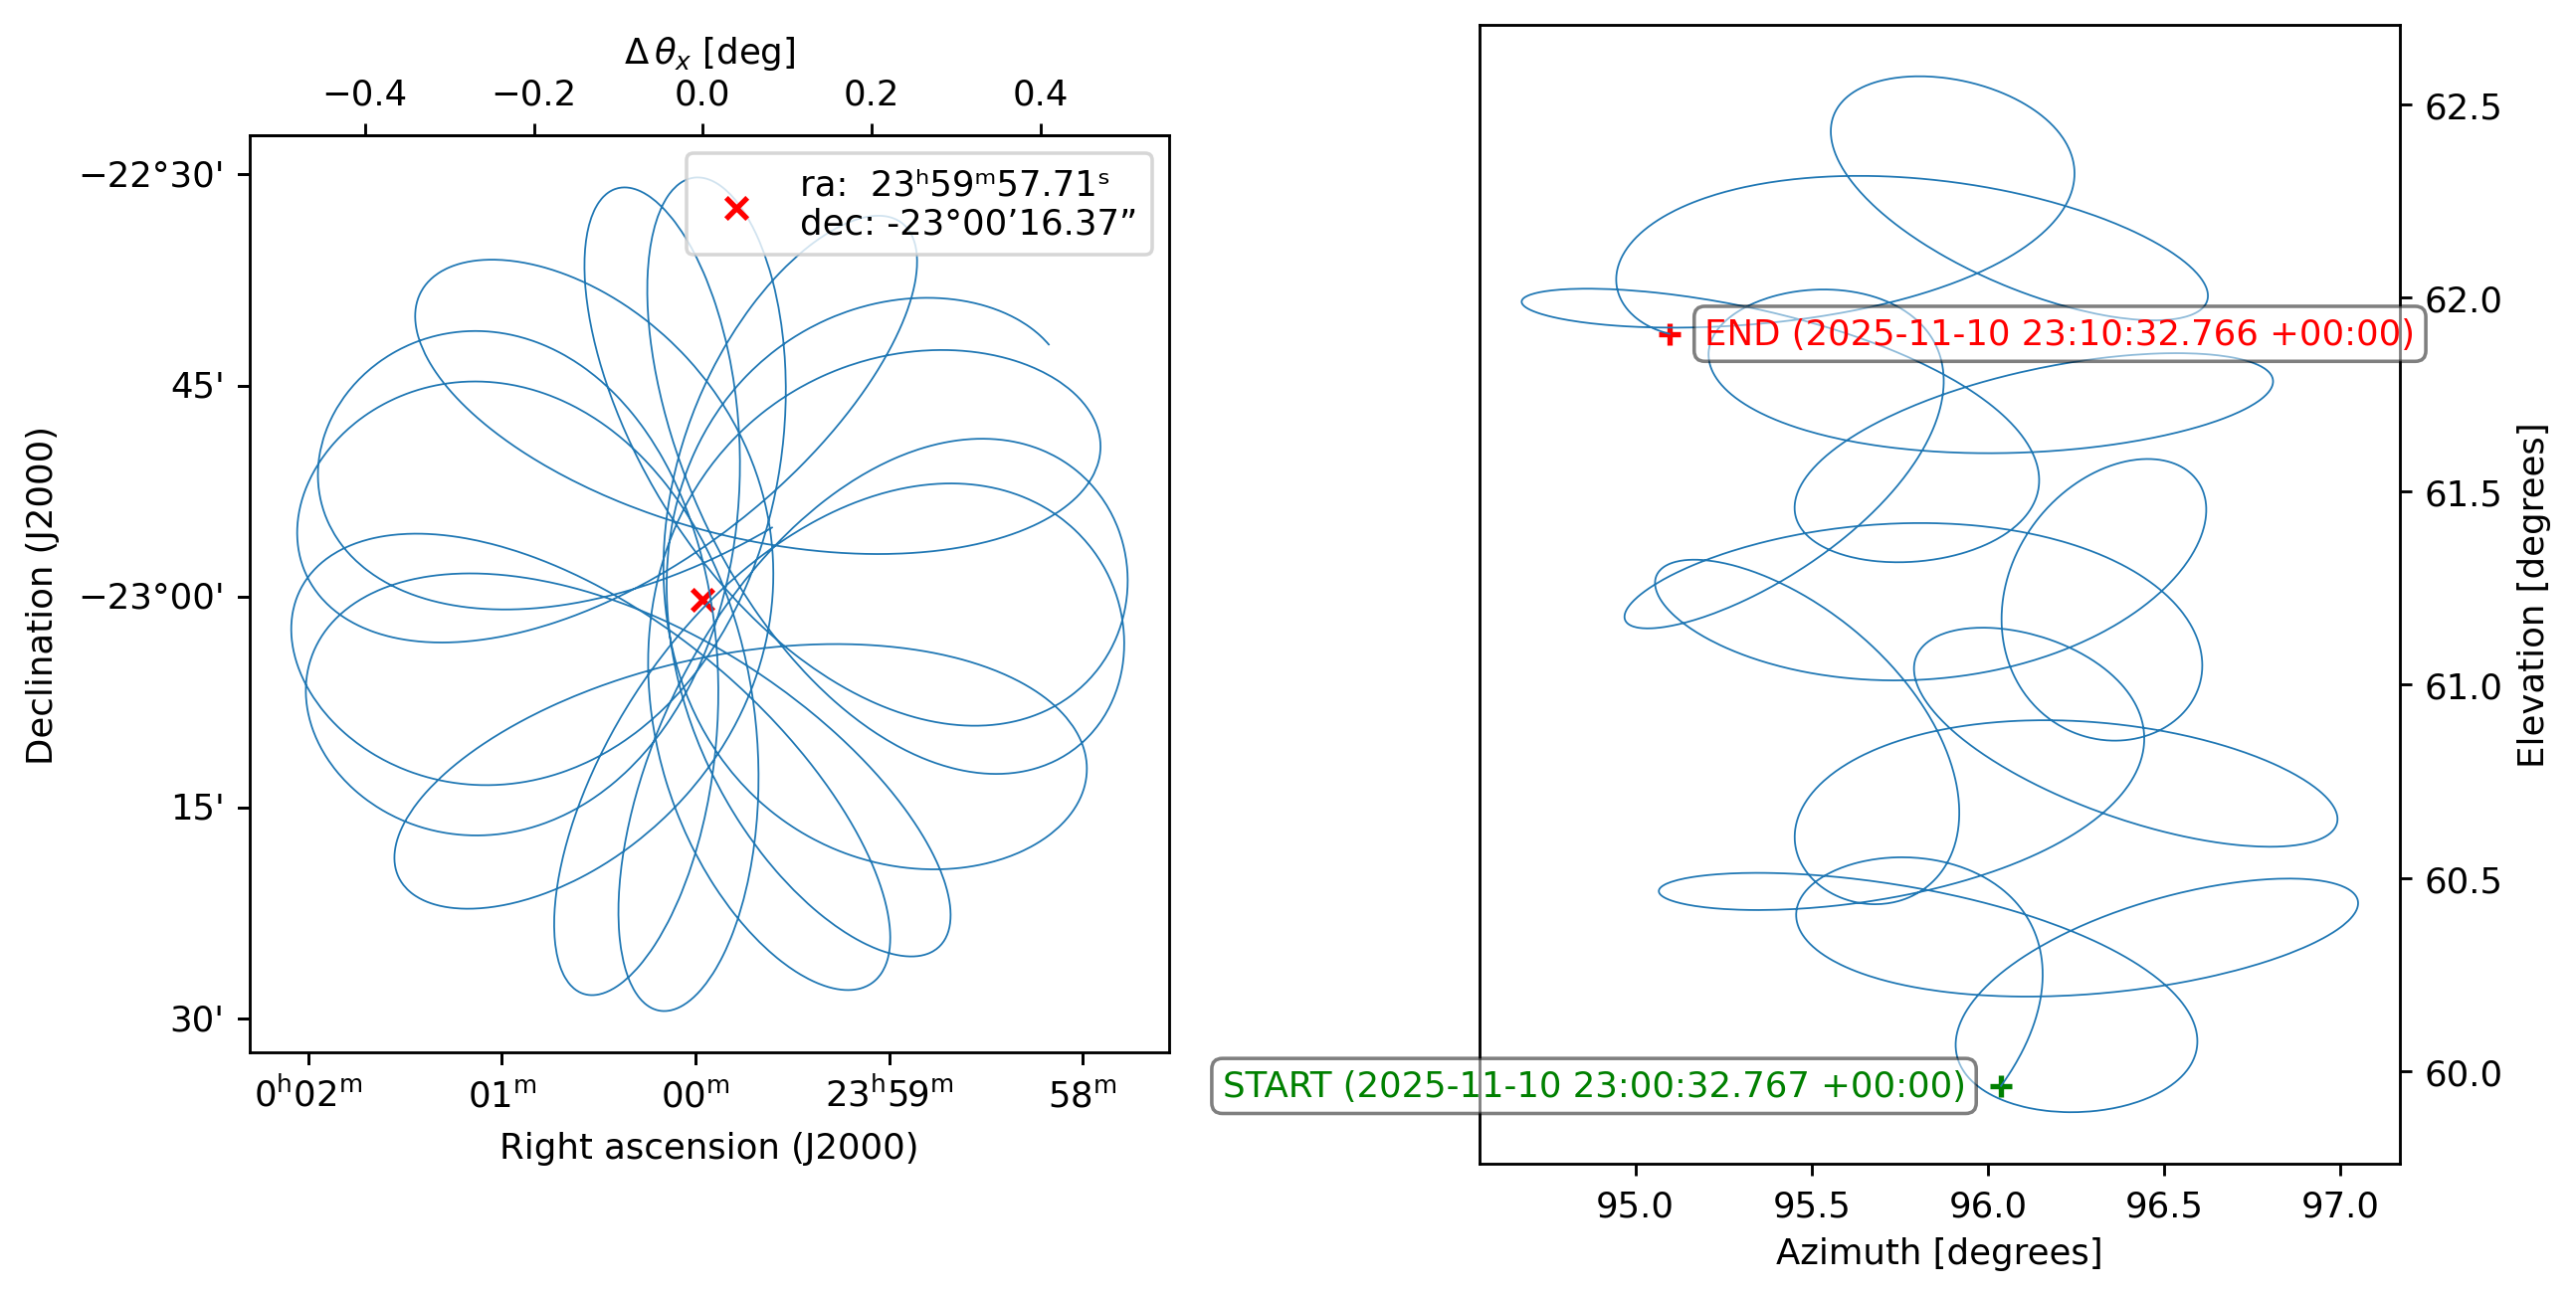

In [4]:
from maria import Planner

planner = Planner(target=input_map, site="llano_de_chajnantor", constraints={"el": (60, 90)})
plans = planner.generate_plans(total_duration=900,  # in seconds
                               sample_rate=50)  # in Hz

plans[0].plot()
print(plans)

In [5]:
sim = maria.Simulation(
    instrument,
    plans=plans,
    site="llano_de_chajnantor",
    atmosphere="2d",
    atmosphere_kwargs={"weather": {"pwv": 0.5}},
    map=input_map
)

print(sim)

Simulation
├ Instrument(1 array)
│ ├ arrays:
│ │            n     FOV baseline        bands polarized
│ │  array1  652  0.478°      0 m  [f090,f150]      True
│ │ 
│ └ bands:
│       name   center   width    η         NEP      NET_RJ         NET_CMB     FWHM
│    0  f090   90 GHz  20 GHz  0.5  5.445 aW√s  40 uK_RJ√s  49.13 uK_CMB√s   1.458’
│    1  f150  150 GHz  30 GHz  0.5  12.25 aW√s  60 uK_RJ√s    104 uK_CMB√s  0.8748’
├ Site:
│   region: chajnantor
│   timezone: America/Santiago
│   location:
│     longitude: 67°45’17.28” W
│     latitude:  23°01’45.84” S
│     altitude: 5064 m
│   seasonal: True
│   diurnal: True
├ PlanList(2 plans, 900 s):
│                            start_time duration     target(ra,dec)    center(az,el)
│ chunk                                                                             
│ 0      2025-11-10 23:00:32.767 +00:00    600 s       (360°, -23°)  (95.92°, 61.2°)
│ 1      2025-11-10 23:11:10.267 +00:00    300 s  (2.721’, -23.01°)  (95.5°, 63.02°)
├ '2d

2025-11-10 15:36:19.592 INFO: Simulating observation 1 of 2


Constructing atmosphere:   0%|                | 0/8 [00:00<?, ?it/s]

Constructing atmosphere:  12%|██              | 1/8 [00:01<00:13,  1.94s/it]

Constructing atmosphere:  25%|████            | 2/8 [00:04<00:12,  2.02s/it]

Constructing atmosphere:  38%|██████          | 3/8 [00:06<00:10,  2.06s/it]

Constructing atmosphere:  50%|████████        | 4/8 [00:09<00:09,  2.44s/it]

Constructing atmosphere:  62%|██████████      | 5/8 [00:11<00:06,  2.29s/it]

Constructing atmosphere:  75%|████████████    | 6/8 [00:13<00:04,  2.17s/it]

Constructing atmosphere:  88%|██████████████  | 7/8 [00:15<00:02,  2.09s/it]

Constructing atmosphere: 100%|████████████████| 8/8 [00:17<00:00,  2.11s/it]

Constructing atmosphere: 100%|████████████████| 8/8 [00:17<00:00,  2.15s/it]

Generating turbulence:   0%|                | 0/8 [00:00<?, ?it/s]

Generating turbulence:  50%|████████        | 4/8 [00:00<00:00, 31.95it/s]

Generating turbulence: 100%|████████████████| 8/8 [00:00<00:00, 18.40it/s]

Generating turbulence: 100%|████████████████| 8/8 [00:00<00:00, 19.62it/s]

Sampling turbulence:   0%|                | 0/8 [00:00<?, ?it/s]

Sampling turbulence:  12%|██              | 1/8 [00:01<00:10,  1.53s/it]

Sampling turbulence:  25%|████            | 2/8 [00:02<00:06,  1.06s/it]

Sampling turbulence:  38%|██████          | 3/8 [00:03<00:04,  1.07it/s]

Sampling turbulence:  50%|████████        | 4/8 [00:03<00:03,  1.15it/s]

Sampling turbulence:  62%|██████████      | 5/8 [00:04<00:02,  1.19it/s]

Sampling turbulence:  75%|████████████    | 6/8 [00:05<00:01,  1.20it/s]

Sampling turbulence:  88%|██████████████  | 7/8 [00:06<00:00,  1.21it/s]

Sampling turbulence: 100%|████████████████| 8/8 [00:07<00:00,  1.21it/s]

Sampling turbulence: 100%|████████████████| 8/8 [00:07<00:00,  1.13it/s]

Computing atmospheric emission:   0%|                | 0/2 [00:00<?, ?it/s]

Computing atmospheric emission:   0%|                | 0/2 [00:00<?, ?it/s, band=f090]

Computing atmospheric emission:  50%|████████        | 1/2 [00:01<00:01,  1.77s/it, band=f090]

Computing atmospheric emission:  50%|████████        | 1/2 [00:01<00:01,  1.77s/it, band=f150]

Computing atmospheric emission: 100%|████████████████| 2/2 [00:02<00:00,  1.01s/it, band=f150]

Computing atmospheric emission: 100%|████████████████| 2/2 [00:02<00:00,  1.12s/it, band=f150]

Sampling map:   0%|                | 0/2 [00:00<?, ?it/s, band=, channel=, stokes=]

Sampling map:   0%|                | 0/2 [00:00<?, ?it/s, band=f090]               

Sampling map:   0%|                | 0/2 [00:04<?, ?it/s, band=f090, channel=(0 Hz, inf Hz), stokes=I]

Sampling map:   0%|                | 0/2 [00:04<?, ?it/s, band=f090, channel=(0 Hz, inf Hz), stokes=Q]

Sampling map:   0%|                | 0/2 [00:05<?, ?it/s, band=f090, channel=(0 Hz, inf Hz), stokes=U]

Sampling map:   0%|                | 0/2 [00:05<?, ?it/s, band=f090, channel=(0 Hz, inf Hz), stokes=V]

Sampling map:  50%|████████        | 1/2 [00:05<00:05,  5.21s/it, band=f090, channel=(0 Hz, inf Hz), stokes=V]

Sampling map:  50%|████████        | 1/2 [00:05<00:05,  5.21s/it, band=f150]                                  

Sampling map:  50%|████████        | 1/2 [00:08<00:05,  5.21s/it, band=f150, channel=(0 Hz, inf Hz), stokes=I]

Sampling map:  50%|████████        | 1/2 [00:08<00:05,  5.21s/it, band=f150, channel=(0 Hz, inf Hz), stokes=Q]

Sampling map:  50%|████████        | 1/2 [00:09<00:05,  5.21s/it, band=f150, channel=(0 Hz, inf Hz), stokes=U]

Sampling map:  50%|████████        | 1/2 [00:09<00:05,  5.21s/it, band=f150, channel=(0 Hz, inf Hz), stokes=V]

Sampling map: 100%|████████████████| 2/2 [00:09<00:00,  4.48s/it, band=f150, channel=(0 Hz, inf Hz), stokes=V]

Sampling map: 100%|████████████████| 2/2 [00:09<00:00,  4.59s/it, band=f150, channel=(0 Hz, inf Hz), stokes=V]

Generating noise:   0%|                | 0/2 [00:00<?, ?it/s]

Generating noise:   0%|                | 0/2 [00:00<?, ?it/s, band=f090]

Generating noise:  50%|████████        | 1/2 [00:00<00:00,  1.68it/s, band=f090]

Generating noise:  50%|████████        | 1/2 [00:00<00:00,  1.68it/s, band=f150]

Generating noise: 100%|████████████████| 2/2 [00:00<00:00,  2.38it/s, band=f150]

Generating noise: 100%|████████████████| 2/2 [00:00<00:00,  2.23it/s, band=f150]

2025-11-10 15:37:10.983 INFO: Simulated observation 1 of 2 in 51.38 s


2025-11-10 15:37:10.983 INFO: Simulating observation 2 of 2


Constructing atmosphere:   0%|                | 0/8 [00:00<?, ?it/s]

Constructing atmosphere:  12%|██              | 1/8 [00:00<00:04,  1.58it/s]

Constructing atmosphere:  25%|████            | 2/8 [00:01<00:04,  1.47it/s]

Constructing atmosphere:  38%|██████          | 3/8 [00:02<00:03,  1.47it/s]

Constructing atmosphere:  50%|████████        | 4/8 [00:02<00:03,  1.30it/s]

Constructing atmosphere:  62%|██████████      | 5/8 [00:03<00:02,  1.36it/s]

Constructing atmosphere:  75%|████████████    | 6/8 [00:04<00:01,  1.33it/s]

Constructing atmosphere:  88%|██████████████  | 7/8 [00:05<00:00,  1.38it/s]

Constructing atmosphere: 100%|████████████████| 8/8 [00:05<00:00,  1.34it/s]

Constructing atmosphere: 100%|████████████████| 8/8 [00:05<00:00,  1.37it/s]

Generating turbulence:   0%|                | 0/8 [00:00<?, ?it/s]

Generating turbulence:  62%|██████████      | 5/8 [00:00<00:00, 44.19it/s]

Generating turbulence: 100%|████████████████| 8/8 [00:00<00:00, 32.27it/s]

Sampling turbulence:   0%|                | 0/8 [00:00<?, ?it/s]

Sampling turbulence:  12%|██              | 1/8 [00:01<00:08,  1.22s/it]

Sampling turbulence:  25%|████            | 2/8 [00:01<00:04,  1.21it/s]

Sampling turbulence:  38%|██████          | 3/8 [00:02<00:03,  1.42it/s]

Sampling turbulence:  50%|████████        | 4/8 [00:02<00:02,  1.52it/s]

Sampling turbulence:  62%|██████████      | 5/8 [00:03<00:01,  1.60it/s]

Sampling turbulence:  75%|████████████    | 6/8 [00:04<00:01,  1.64it/s]

Sampling turbulence:  88%|██████████████  | 7/8 [00:04<00:00,  1.67it/s]

Sampling turbulence: 100%|████████████████| 8/8 [00:05<00:00,  1.69it/s]

Sampling turbulence: 100%|████████████████| 8/8 [00:05<00:00,  1.53it/s]

Computing atmospheric emission:   0%|                | 0/2 [00:00<?, ?it/s]

Computing atmospheric emission:   0%|                | 0/2 [00:00<?, ?it/s, band=f090]

Computing atmospheric emission:  50%|████████        | 1/2 [00:01<00:01,  1.51s/it, band=f090]

Computing atmospheric emission:  50%|████████        | 1/2 [00:01<00:01,  1.51s/it, band=f150]

Computing atmospheric emission: 100%|████████████████| 2/2 [00:01<00:00,  1.38it/s, band=f150]

Computing atmospheric emission: 100%|████████████████| 2/2 [00:01<00:00,  1.19it/s, band=f150]

Sampling map:   0%|                | 0/2 [00:00<?, ?it/s, band=, channel=, stokes=]

Sampling map:   0%|                | 0/2 [00:00<?, ?it/s, band=f090]               

Sampling map:   0%|                | 0/2 [00:03<?, ?it/s, band=f090, channel=(0 Hz, inf Hz), stokes=I]

Sampling map:   0%|                | 0/2 [00:03<?, ?it/s, band=f090, channel=(0 Hz, inf Hz), stokes=Q]

Sampling map:   0%|                | 0/2 [00:03<?, ?it/s, band=f090, channel=(0 Hz, inf Hz), stokes=U]

Sampling map:   0%|                | 0/2 [00:03<?, ?it/s, band=f090, channel=(0 Hz, inf Hz), stokes=V]

Sampling map:  50%|████████        | 1/2 [00:03<00:03,  3.42s/it, band=f090, channel=(0 Hz, inf Hz), stokes=V]

Sampling map:  50%|████████        | 1/2 [00:03<00:03,  3.42s/it, band=f150]                                  

Sampling map:  50%|████████        | 1/2 [00:05<00:03,  3.42s/it, band=f150, channel=(0 Hz, inf Hz), stokes=I]

Sampling map:  50%|████████        | 1/2 [00:05<00:03,  3.42s/it, band=f150, channel=(0 Hz, inf Hz), stokes=Q]

Sampling map:  50%|████████        | 1/2 [00:05<00:03,  3.42s/it, band=f150, channel=(0 Hz, inf Hz), stokes=U]

Sampling map:  50%|████████        | 1/2 [00:05<00:03,  3.42s/it, band=f150, channel=(0 Hz, inf Hz), stokes=V]

Sampling map: 100%|████████████████| 2/2 [00:05<00:00,  2.49s/it, band=f150, channel=(0 Hz, inf Hz), stokes=V]

Sampling map: 100%|████████████████| 2/2 [00:05<00:00,  2.63s/it, band=f150, channel=(0 Hz, inf Hz), stokes=V]

Generating noise:   0%|                | 0/2 [00:00<?, ?it/s]

Generating noise:   0%|                | 0/2 [00:00<?, ?it/s, band=f090]

Generating noise:  50%|████████        | 1/2 [00:00<00:00,  2.32it/s, band=f090]

Generating noise:  50%|████████        | 1/2 [00:00<00:00,  2.32it/s, band=f150]

Generating noise: 100%|████████████████| 2/2 [00:00<00:00,  3.96it/s, band=f150]

Generating noise: 100%|████████████████| 2/2 [00:00<00:00,  3.58it/s, band=f150]

2025-11-10 15:37:37.303 INFO: Simulated observation 2 of 2 in 26.31 s


[TOD(shape=(652, 30000), fields=['atmosphere', 'map', 'noise'], units='K_RJ', start=2025-11-10 23:10:32.746 +00:00, duration=600.0s, sample_rate=50.0Hz, metadata={'atmosphere': True, 'sim_time': <Arrow [2025-11-10T15:36:59.021642+00:00]>, 'altitude': 5064.0, 'region': 'chajnantor', 'pwv': 0.5, 'base_temperature': 276.815}), TOD(shape=(652, 15000), fields=['atmosphere', 'map', 'noise'], units='K_RJ', start=2025-11-10 23:16:10.246 +00:00, duration=300.0s, sample_rate=50.0Hz, metadata={'atmosphere': True, 'sim_time': <Arrow [2025-11-10T15:37:31.690219+00:00]>, 'altitude': 5064.0, 'region': 'chajnantor', 'pwv': 1.754, 'base_temperature': 276.655})]


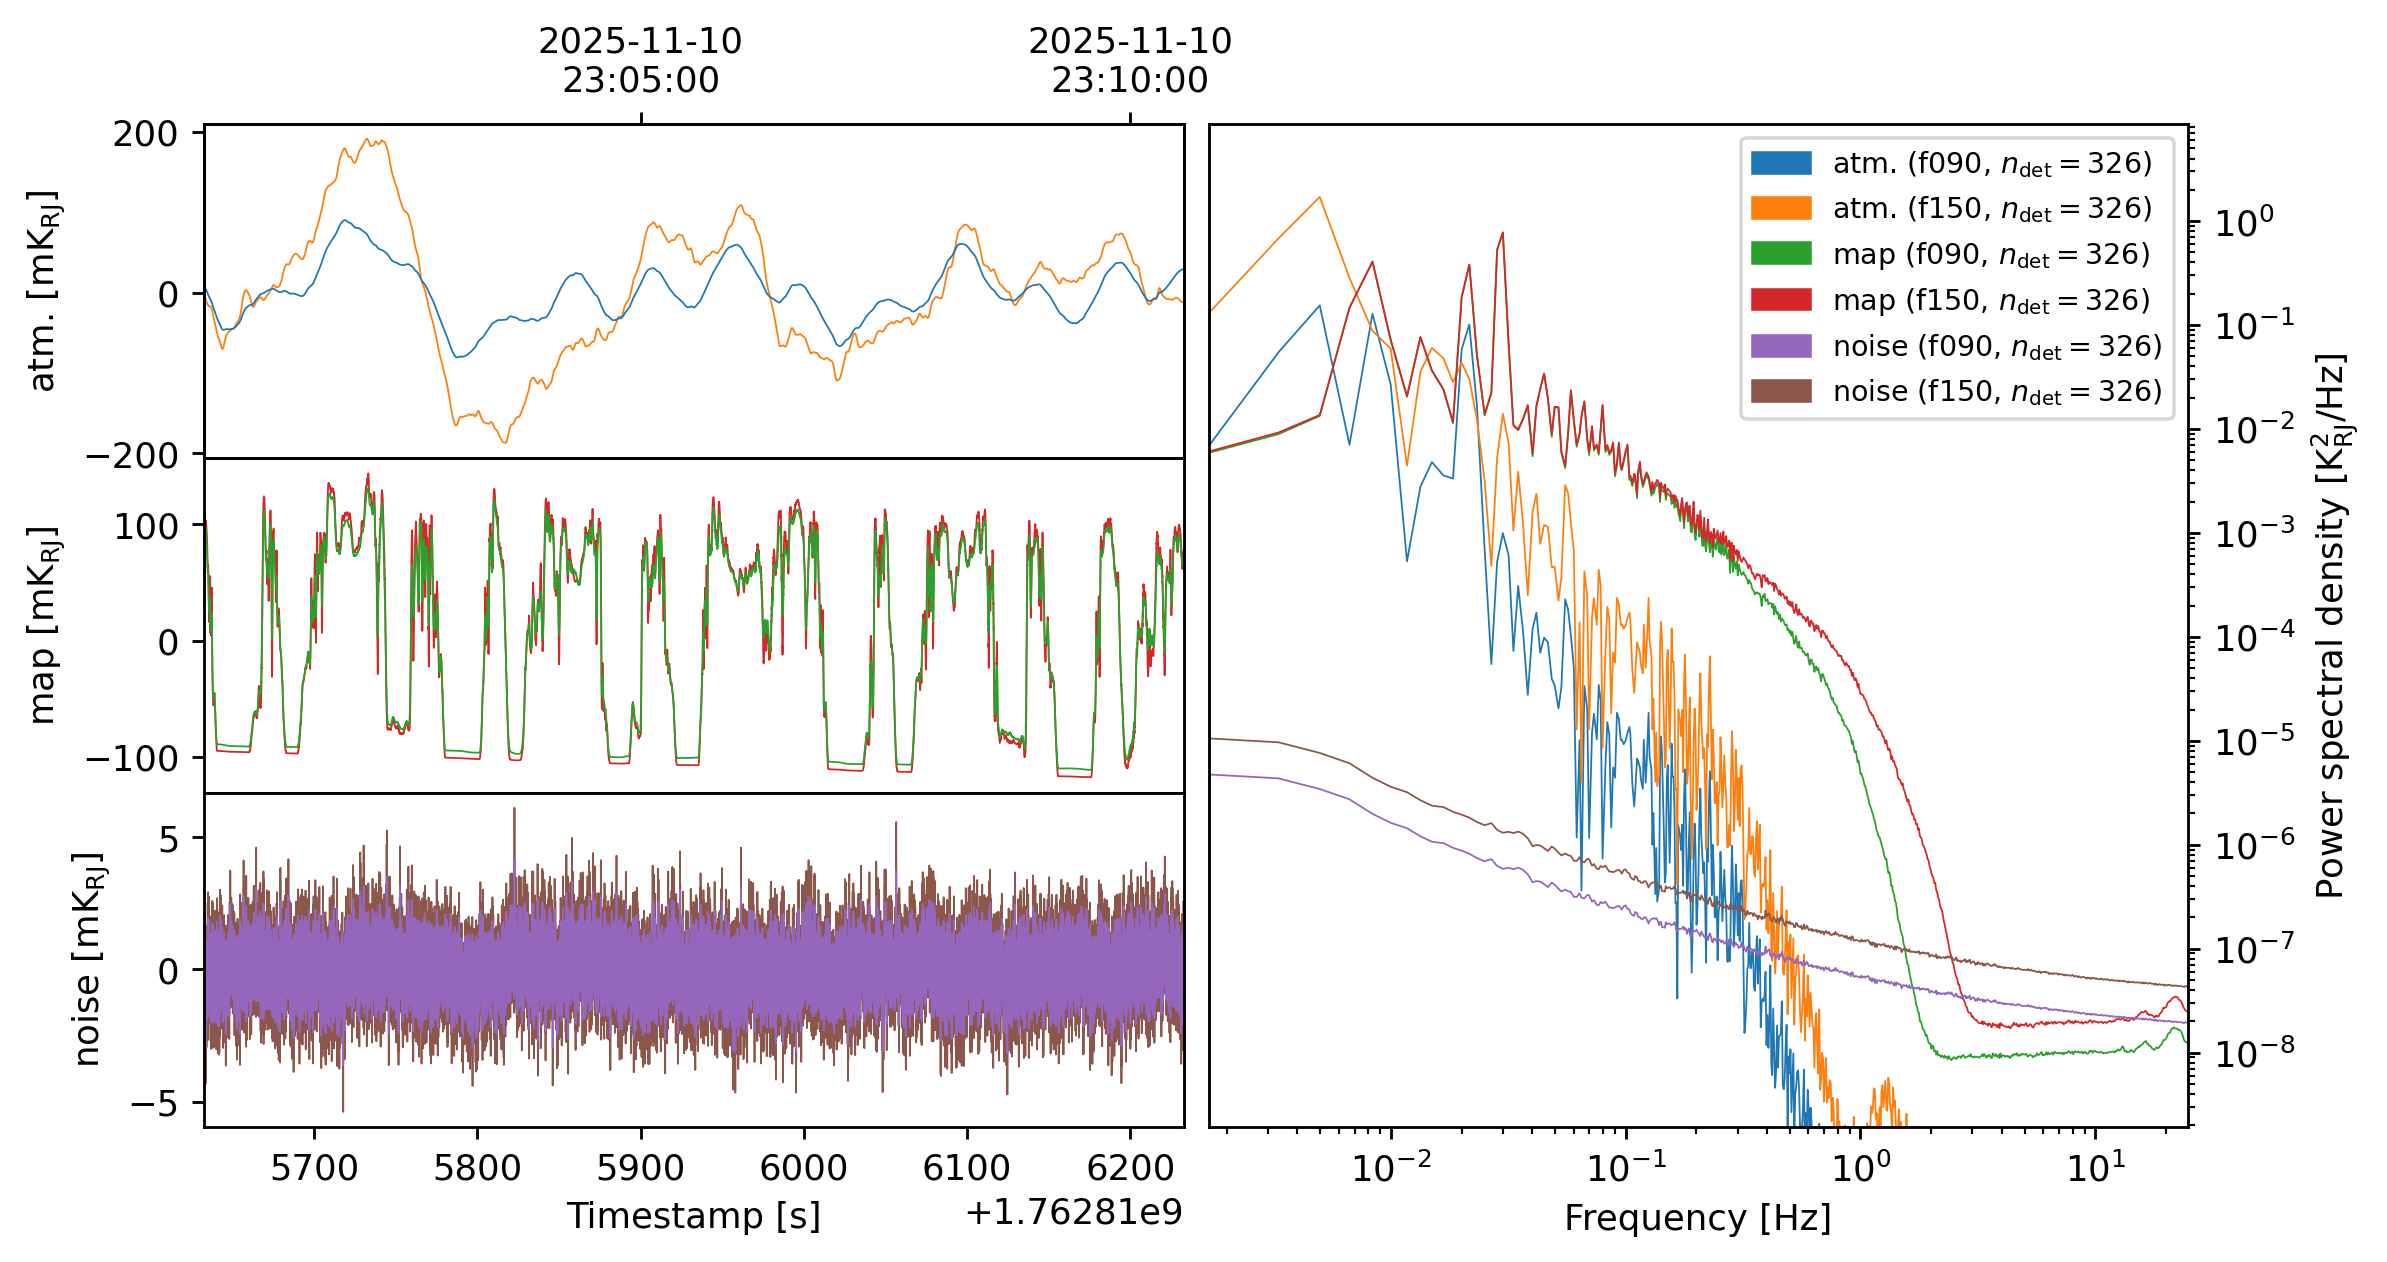

In [6]:
tods = sim.run()

print(tods)
tods[0].plot()

In [7]:
tods

[TOD(shape=(652, 30000), fields=['atmosphere', 'map', 'noise'], units='K_RJ', start=2025-11-10 23:10:32.746 +00:00, duration=600.0s, sample_rate=50.0Hz, metadata={'atmosphere': True, 'sim_time': <Arrow [2025-11-10T15:36:59.021642+00:00]>, 'altitude': 5064.0, 'region': 'chajnantor', 'pwv': 0.5, 'base_temperature': 276.815}),
 TOD(shape=(652, 15000), fields=['atmosphere', 'map', 'noise'], units='K_RJ', start=2025-11-10 23:16:10.246 +00:00, duration=300.0s, sample_rate=50.0Hz, metadata={'atmosphere': True, 'sim_time': <Arrow [2025-11-10T15:37:31.690219+00:00]>, 'altitude': 5064.0, 'region': 'chajnantor', 'pwv': 1.754, 'base_temperature': 276.655})]

In [8]:
from maria.mappers import BinMapper

mapper = BinMapper(
    center=(0, -23),
    stokes="IQU",
    frame="ra/dec",
    width=1.0,
    height=1.0,
    resolution=1.0 / 256,
    tod_preprocessing={
        "window": {"name": "tukey", "kwargs": {"alpha": 0.1}},
        "remove_spline": {"knot_spacing": 60, "remove_el_gradient": True},
        "remove_modes": {"modes_to_remove": [0]},
    },
    map_postprocessing={
        "gaussian_filter": {"sigma": 1},
        # "median_filter": {"size": 1},
    },
    units="mK_RJ",
)

mapper.add_tods(tods)

output_map = mapper.run()

print(output_map)

Preprocessing TODs: |                | 0/0 [00:00<?, ?it/s]

Preprocessing TODs: |                | 0/0 [00:00<?, ?it/s]

Preprocessing TODs:   0%|                | 0/2 [00:00<?, ?it/s]

Preprocessing TODs:  50%|████████        | 1/2 [00:01<00:01,  1.69s/it]

Preprocessing TODs: 100%|████████████████| 2/2 [00:02<00:00,  1.39s/it]

Preprocessing TODs: 100%|████████████████| 2/2 [00:02<00:00,  1.43s/it]

Mapping band f090:   0%|          | 0/2 [00:00<?, ?it/s, stokes=I, tod=1/2]

Mapping band f090:   0%|          | 0/2 [00:02<?, ?it/s, stokes=I, tod=1/2]

Mapping band f090:   0%|          | 0/2 [00:02<?, ?it/s, stokes=Q, tod=1/2]

Mapping band f090:   0%|          | 0/2 [00:02<?, ?it/s, stokes=U, tod=1/2]

Mapping band f090:  50%|█████     | 1/2 [00:02<00:02,  2.38s/it, stokes=U, tod=1/2]

Mapping band f090:  50%|█████     | 1/2 [00:03<00:02,  2.38s/it, stokes=I, tod=2/2]

Mapping band f090:  50%|█████     | 1/2 [00:03<00:02,  2.38s/it, stokes=Q, tod=2/2]

Mapping band f090:  50%|█████     | 1/2 [00:03<00:02,  2.38s/it, stokes=U, tod=2/2]

Mapping band f090: 100%|██████████| 2/2 [00:03<00:00,  1.76s/it, stokes=U, tod=2/2]

Mapping band f090: 100%|██████████| 2/2 [00:03<00:00,  1.85s/it, stokes=U, tod=2/2]


2025-11-10 15:37:48.066 INFO: Ran mapper for band f090 in 3.707 s.


Mapping band f150:   0%|          | 0/2 [00:00<?, ?it/s, stokes=I, tod=1/2]

Mapping band f150:   0%|          | 0/2 [00:02<?, ?it/s, stokes=I, tod=1/2]

Mapping band f150:   0%|          | 0/2 [00:02<?, ?it/s, stokes=Q, tod=1/2]

Mapping band f150:   0%|          | 0/2 [00:02<?, ?it/s, stokes=U, tod=1/2]

Mapping band f150:  50%|█████     | 1/2 [00:02<00:02,  2.32s/it, stokes=U, tod=1/2]

Mapping band f150:  50%|█████     | 1/2 [00:03<00:02,  2.32s/it, stokes=I, tod=2/2]

Mapping band f150:  50%|█████     | 1/2 [00:03<00:02,  2.32s/it, stokes=Q, tod=2/2]

Mapping band f150:  50%|█████     | 1/2 [00:03<00:02,  2.32s/it, stokes=U, tod=2/2]

Mapping band f150: 100%|██████████| 2/2 [00:03<00:00,  1.69s/it, stokes=U, tod=2/2]

Mapping band f150: 100%|██████████| 2/2 [00:03<00:00,  1.78s/it, stokes=U, tod=2/2]


2025-11-10 15:37:51.649 INFO: Ran mapper for band f150 in 3.57 s.


ProjectedMap:
  shape(stokes, nu, y, x): (3, 2, 256, 256)
  stokes: IQU
  nu: [ 90. 150.] GHz
  t: naive
  z: naive
  quantity: rayleigh_jeans_temperature
  units: mK_RJ
    min: -2.480e+02
    max: 2.378e+02
  center:
    ra:  00ʰ00ᵐ0.00ˢ
    dec: -23°00’0.00”
  size(y, x): (1°, 1°)
  resolution(y, x): (14.06”, 14.06”)
  beam(maj, min, rot): [[1.45801568 1.45801568 0.        ]
 [0.87480941 0.87480941 0.        ]]’
  memory: 6.291 MB


Note that we can't see any of the circular polarization, since our instrument isn't sensitive to it.

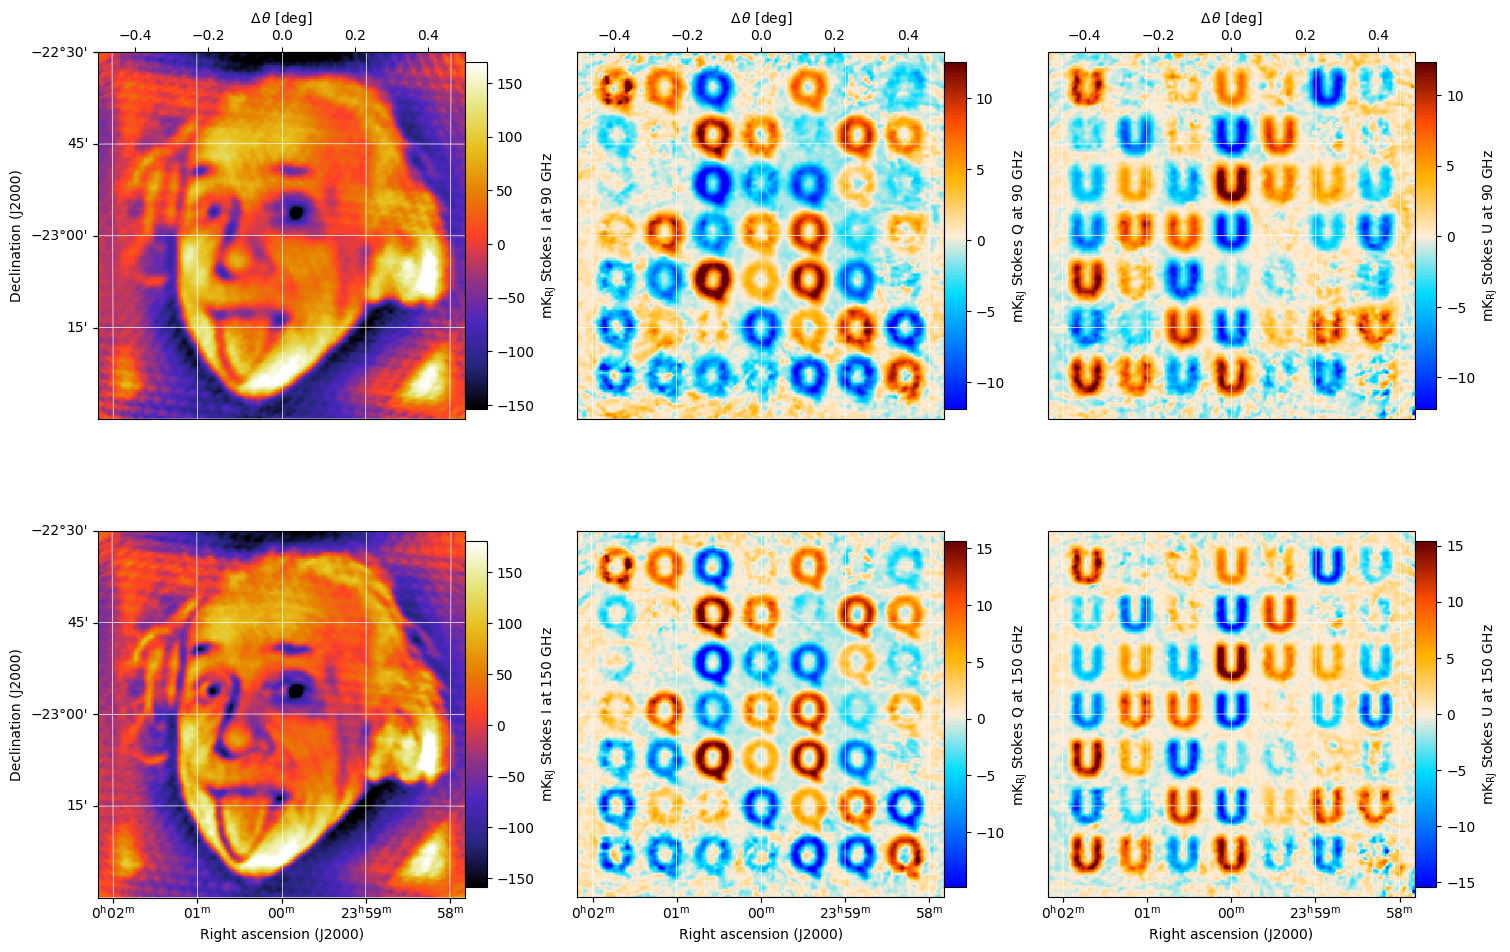

In [9]:
output_map.plot(stokes=["I", "Q", "U"], nu_index=[[0], [1]])